# Neural Network Autoencoder Homework

This notebook serves as the skeleton for implementing an 8‑3‑8 autoencoder from scratch using NumPy. Each section corresponds to a step in building, training, and analyzing the network. Fill in the code cells with your implementation and results.

## Overview

The goal is to implement and train a neural network with one hidden layer to reproduce the input one‑hot vectors. The network architecture consists of:

- An input layer of 8 units.
- A hidden layer with 3 units (plus a bias).
- An output layer of 8 units.

The tasks include:

1. Generating the dataset of one‑hot vectors.
2. Initializing network parameters.
3. Implementing activation functions, loss, and backpropagation.
4. Training the network using gradient descent.
5. Monitoring learning performance and plotting the loss curve.
6. Analyzing the hidden layer activations and learned weights.

Follow the sections below to complete the assignment.

In [448]:
# Import required libraries
import numpy as np
import matplotlib.pyplot as plt

# Set a random seed for reproducibility (optional)
np.random.seed(42)

## Generate Dataset

Create the dataset consisting of the 8 one‑hot vectors. Each example has 7 zeros and 1 one. The output you aim for is the same as the input.

In [449]:
# Generate 8 one‑hot vectors as input and target data
X = np.eye(8)  # shape (8, 8)
Y = X.copy()    # same as input

print('Input dataset X:')
print(X)

Input dataset X:
[[1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1.]]


## Initialize Parameters

Initialize the weights and biases for the network. Use a suitable initialization strategy (e.g., Xavier/Glorot initialization) to help the network converge.

In [450]:
# Initialize weights and biases
# W1: hidden layer weights (shape 3×8), b1: hidden layer biases (shape 3×1)
# W2: output layer weights (shape 8×3), b2: output layer biases (shape 8×1)

input_size = 8
hidden_size = 3
output_size = 8

# Xavier/Glorot initialization for sigmoid activation
limit_W1 = np.sqrt(6 / (input_size + hidden_size))
limit_W2 = np.sqrt(6 / (hidden_size + output_size))

W1 = np.random.uniform(-limit_W1, limit_W1, (hidden_size, input_size))
b1 = np.zeros((hidden_size, 1))
W2 = np.random.uniform(-limit_W2, limit_W2, (output_size, hidden_size))
b2 = np.zeros((output_size, 1))

# Print shapes to verify
print('W1 shape:', W1.shape)
print('b1 shape:', b1.shape)
print('W2 shape:', W2.shape)
print('b2 shape:', b2.shape)

W1 shape: (3, 8)
b1 shape: (3, 1)
W2 shape: (8, 3)
b2 shape: (8, 1)


## Activation and Loss Functions

Implement the sigmoid activation function and the binary cross‑entropy loss. These will be used in the forward pass and the computation of gradients.

In [451]:
# Sigmoid activation function
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

# Binary cross‑entropy loss (averaged over outputs and samples)
def bce_loss(y, y_hat):
    # Add a small epsilon to avoid log(0)
    eps = 1e-12
    y_hat = np.clip(y_hat, eps, 1 - eps)
    return -np.mean(y * np.log(y_hat) + (1 - y) * np.log(1 - y_hat))

# Example: test activation and loss
z_example = np.array([[0], [1], [-1]])
a_example = sigmoid(z_example)
print('Sigmoid example:', a_example.flatten())

y_true = np.array([[1, 0], [0, 1]])
y_pred = np.array([[0.9, 0.1], [0.1, 0.9]])
print('BCE loss example:', bce_loss(y_true, y_pred))

Sigmoid example: [0.5        0.73105858 0.26894142]
BCE loss example: 0.10536051565782628


## Forward and Backpropagation

Implement the forward pass to compute the network outputs given the inputs. Then implement backpropagation to compute gradients of the loss with respect to weights and biases. Use vectorized operations for efficiency.

In [452]:
from tkinter import W


print(f"teta: {W1}")
print(f"teta2: {W2}")


teta: [[-0.18531653  0.66574915  0.34267776  0.14572824 -0.50809414 -0.50812977
  -0.65275376  0.54087801]
 [ 0.14935677  0.30734357 -0.70814363  0.69410285  0.49105032 -0.42490329
  -0.46997567 -0.46764253]
 [-0.28915337  0.03656767 -0.10052387 -0.308375    0.16521767 -0.53250286
  -0.3070227  -0.19739664]]
teta2: [[-0.06488893  0.42123281 -0.44361122]
 [ 0.02102566  0.13650536 -0.66993714]
 [ 0.15885427 -0.48666812 -0.64246138]
 [ 0.66304788  0.68778409  0.45553307]
 [-0.28860459 -0.59427767  0.27213022]
 [-0.08840063 -0.55828653 -0.00712418]
 [-0.68775373  0.6046063  -0.35630558]
 [ 0.24006132 -0.27812117  0.02964243]]


In [453]:
# Forward propagation
def sigmoid_prime_from_activation(a):
    # f'(z) when a = sigmoid(z)
    return a * (1.0 - a)

def _as_col_major(X, D):
    # Ensure X has shape (D, N)
    if X.shape[0] == D:
        return X
    if X.shape[1] == D:
        return X.T
    raise ValueError(f"Incompatible X shape {X.shape}; expected features={D}.")
def forward_pass_hidden_bias(X, W1, b1, W2_tilde):
    """
    X: (D,N) or (N,D)  -> coerced to (D,N)
    W1: (H,D), b1: (H,1)
    W2_tilde: (O,H+1)  # column 0 is output bias column (connects from +1)
    Returns: Z1, A1, A1_tilde, Z2, Y_hat
    """
    D = W1.shape[1]
    X = _as_col_major(X, D)

    Z1 = W1 @ X + b1                 # (H, N)
    A1 = sigmoid(Z1)                 # (H, N)
    A1_tilde = np.vstack([np.ones((1, A1.shape[1])), A1])  # (H+1, N)

    Z2 = W2_tilde @ A1_tilde         # (O, N)   (no separate b2)
    Y_hat = sigmoid(Z2)              # (O, N)
    return Z1, A1, A1_tilde, Z2, Y_hat



# Backpropagation
def backprop_hidden_bias_vectorized(X, Y, Z1, A1, A1_tilde, Z2, Y_hat,
                                    W1, b1, W2_tilde, lambda_reg=0.0,
                                    return_deltas=False):
    D = W1.shape[1]
    X = _as_col_major(X, D)
    N = X.shape[1]

    delta_out = Y_hat - Y  # sigmoid + BCE derivative
    hidden_back = W2_tilde[:, 1:].T @ delta_out
    delta_hid = hidden_back * A1 * (1.0 - A1)

    dW2_tilde = (delta_out @ A1_tilde.T) / N
    db1 = np.mean(delta_hid, axis=1, keepdims=True)
    dW1 = (delta_hid @ X.T) / N

    dW1 += lambda_reg * W1
    dW2_tilde[:, 1:] += lambda_reg * W2_tilde[:, 1:]

    if return_deltas:
        return dW1, db1, dW2_tilde, delta_hid, delta_out
    return dW1, db1, dW2_tilde

def iterate_minibatches(X, Y, batch_size, shuffle=True):
    N = X.shape[1]
    indices = np.arange(N)
    if shuffle:
        np.random.shuffle(indices)
    for start in range(0, N, batch_size):
        batch_idx = indices[start:start + batch_size]
        yield X[:, batch_idx], Y[:, batch_idx]

## Training Loop

Implement the gradient descent loop to update parameters until the network converges. Monitor the loss at each epoch and stop when a desired threshold is reached or after a fixed number of epochs.

In [ ]:
# Training parameters
# del loss_history
# Training hyperparameters
learning_rate = 0.7989
max_epochs = 10000
batch_size = 4
lambda_reg = 0.0
loss_history = []

# Column-major data (features × batch)
X_train = X.T              # (8, 8)
Y_train = Y.T              # (8, 8)

# Xavier init with bias folded into W2_tilde
W1 = np.random.uniform(-limit_W1, limit_W1, (hidden_size, input_size))
b1 = np.zeros((hidden_size, 1))
W2_tilde = np.random.uniform(-limit_W2, limit_W2, (output_size, hidden_size + 1))

for epoch in range(max_epochs):
    epoch_loss = 0.0
    batches = 0

    for X_batch, Y_batch in iterate_minibatches(X_train, Y_train, batch_size):
        Z1, A1, A1_tilde, Z2, Y_hat = forward_pass_hidden_bias(
            X_batch, W1, b1, W2_tilde
        )

        # Binary cross-entropy loss to match delta_out
        batch_loss = bce_loss(Y_batch, Y_hat)
        epoch_loss += batch_loss
        batches += 1

        dW1, db1, dW2_tilde = backprop_hidden_bias_vectorized(
            X_batch, Y_batch, Z1, A1, A1_tilde, Z2, Y_hat,
            W1, b1, W2_tilde, lambda_reg
        )

        W1 -= learning_rate * dW1
        b1 -= learning_rate * db1
        W2_tilde -= learning_rate * dW2_tilde

    loss_history.append(epoch_loss / batches)

    if loss_history[-1] < 1e-3:
        print(f"Early stopping at epoch {epoch + 1} with loss {loss_history[-1]:.6f}")
        break

print("Final loss:", loss_history[-1])



Final loss: 0.0033040306637615955


## Plot Loss Curve

Visualize the decrease in loss over training epochs to observe convergence behavior.

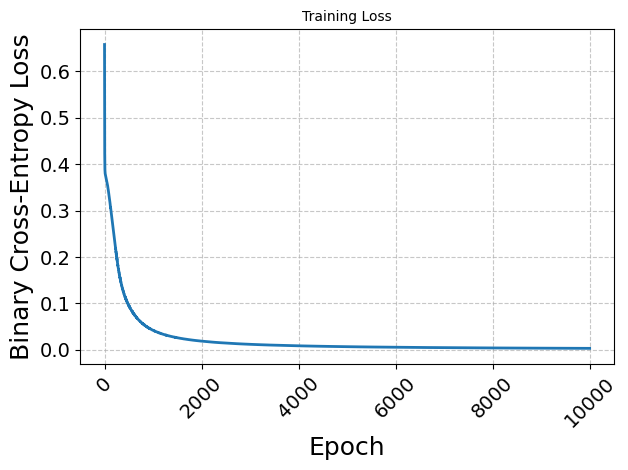

In [455]:
# Create an extremely large figure
plt.figure()  # Much larger figure size
plt.plot(loss_history, linewidth=2)  # Thicker line for better visibility
plt.title('Training Loss', fontsize=10)  # Larger title
plt.xlabel('Epoch', fontsize=18)
plt.ylabel('Binary Cross‑Entropy Loss', fontsize=18)
plt.grid(True, linestyle='--', alpha=0.7)
plt.xticks(fontsize=14, rotation=45)  # Larger tick labels
plt.yticks(fontsize=14)
plt.tight_layout()
plt.show()

## Evaluate and Interpret the Hidden Layer

After training, evaluate the network on all input vectors and analyze the activations of the hidden layer. Compare the raw activations and thresholded values (e.g., > 0.5) to see if the network has learned a binary encoding for each input.

In [456]:
# Compute hidden activations and outputs
Z1, A1, Z2, Y_hat_final = forward_pass(X_train, W1, b1, W2, b2)

# Hidden activations for each input
print('Hidden activations (raw):')
print(A1)

# Threshold the activations to form a binary code
hidden_codes = (A1 > 0.5).astype(int)
print('Hidden activations (thresholded > 0.5):')
print(hidden_codes)

# Compare final outputs to targets
print('Final outputs:')
print(np.round(Y_hat_final, 3))
print('Targets:')
print(Y_train)

Hidden activations (raw):
[[0.99542407 0.00259129 0.80714813 0.00392208 0.99025684 0.04277678
  0.01770067 0.98867173]
 [0.99050265 0.01248979 0.02717837 0.989714   0.00225105 0.01939939
  0.97985839 0.99015913]
 [0.99616305 0.08384726 0.00255463 0.98310976 0.86435789 0.9916981
  0.00700885 0.00818213]]
Hidden activations (thresholded > 0.5):
[[1 0 1 0 1 0 0 1]
 [1 0 0 1 0 0 1 1]
 [1 0 0 1 1 1 0 0]]
Final outputs:
[[0.478 0.492 0.489 0.495 0.39  0.393 0.601 0.586]
 [0.375 0.486 0.505 0.372 0.364 0.341 0.532 0.538]
 [0.276 0.485 0.528 0.247 0.402 0.345 0.383 0.418]
 [0.858 0.512 0.635 0.756 0.741 0.621 0.666 0.793]
 [0.353 0.504 0.438 0.42  0.487 0.561 0.358 0.295]
 [0.343 0.498 0.478 0.364 0.476 0.495 0.366 0.345]
 [0.392 0.494 0.368 0.561 0.271 0.408 0.641 0.479]
 [0.498 0.5   0.546 0.439 0.565 0.509 0.433 0.491]]
Targets:
[[1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0.]
 [

In [457]:
def reconstruction_report(X, Y, W1, b1, W2_tilde, tol=1e-2):
    _, _, _, _, Y_hat = forward_pass_hidden_bias(X, W1, b1, W2_tilde)

    mse = np.mean((Y_hat - Y) ** 2)
    mae = np.mean(np.abs(Y_hat - Y))

    # One-hot recovery: argmax of each column equals the target index
    preds = np.argmax(Y_hat, axis=0)
    targets = np.argmax(Y, axis=0)
    exact = np.sum(preds == targets)
    exact_rate = exact / Y.shape[1]

    # Optional: treat values within tol of the true one-hot vector as correct
    close = np.all(np.abs(Y_hat - Y) < tol, axis=0)
    close_rate = np.sum(close) / Y.shape[1]

    return {
        "mse": mse,
        "mae": mae,
        "exact_match": exact_rate,
        "within_tol": close_rate,
        "Y_hat": Y_hat,
    }

report = reconstruction_report(X_train, Y_train, W1, b1, W2_tilde)
print(report["mse"], report["exact_match"])

2.9671027469939956e-05 1.0


In [458]:
report = reconstruction_report(X_train, Y_train, W1, b1, W2_tilde)

print(f"MSE: {report['mse']:.6e}, exact: {report['exact_match']:.1%}")

Y_hat = report["Y_hat"]

for idx in range(Y_train.shape[1]):
    print(f"\nSample {idx}:")
    print("target :", Y_train[:, idx])
    print("pred   :", np.round(Y_hat[:, idx], 6))

MSE: 2.967103e-05, exact: 100.0%

Sample 0:
target : [1. 0. 0. 0. 0. 0. 0. 0.]
pred   : [0.980461 0.       0.       0.00219  0.001499 0.       0.       0.002814]

Sample 1:
target : [0. 1. 0. 0. 0. 0. 0. 0.]
pred   : [0.0000e+00 9.8792e-01 7.5360e-03 2.0000e-06 3.0000e-06 3.5570e-03
 4.2140e-03 1.0000e-06]

Sample 2:
target : [0. 0. 1. 0. 0. 0. 0. 0.]
pred   : [1.00000e-06 3.67800e-03 9.88856e-01 0.00000e+00 9.38200e-03 0.00000e+00
 2.00000e-06 6.00600e-03]

Sample 3:
target : [0. 0. 0. 1. 0. 0. 0. 0.]
pred   : [0.009027 0.       0.       0.987944 0.       0.002757 0.002415 0.      ]

Sample 4:
target : [0. 0. 0. 0. 1. 0. 0. 0.]
pred   : [9.38100e-03 0.00000e+00 2.12700e-03 0.00000e+00 9.87701e-01 3.35500e-03
 0.00000e+00 3.00000e-06]

Sample 5:
target : [0. 0. 0. 0. 0. 1. 0. 0.]
pred   : [1.00000e-05 4.27600e-03 0.00000e+00 7.00800e-03 6.05000e-03 9.91612e-01
 0.00000e+00 0.00000e+00]

Sample 6:
target : [0. 0. 0. 0. 0. 0. 1. 0.]
pred   : [2.00000e-06 2.85300e-03 0.00000e+00 6.98700e-

## Noise experiment

In [459]:
def noisy_reconstruction_report(X, Y, W1, b1, W2_tilde,
                                noise_std=0.1, clip=True, seed=None):
    rng = np.random.default_rng(seed)
    noise = rng.normal(loc=0.0, scale=noise_std, size=X.shape)
    X_noisy = X + noise
    if clip:
        X_noisy = np.clip(X_noisy, 0.0, 1.0)

    _, _, _, _, Y_hat = forward_pass_hidden_bias(X_noisy, W1, b1, W2_tilde)

    mse = np.mean((Y_hat - Y) ** 2)
    preds = np.argmax(Y_hat, axis=0)
    targets = np.argmax(Y, axis=0)
    exact_rate = np.mean(preds == targets)

    return {
        "X_noisy": X_noisy,
        "Y_hat": Y_hat,
        "mse": mse,
        "exact_match": exact_rate,
    }

In [460]:
for std in [0.05, 0.1, 0.2, 0.3]:
    report = noisy_reconstruction_report(X_train, Y_train, W1, b1, W2_tilde,
                                         noise_std=std, seed=42)
    print(f"std={std:.2f} -> MSE {report['mse']:.4f}, exact {report['exact_match']:.1%}")



idx = np.argmax(np.abs(report["Y_hat"] - Y_train).sum(axis=0))
print("Worst sample target:", Y_train[:, idx])
print("Worst sample pred  :", np.round(report["Y_hat"][:, idx], 3))
print("Noisy input        :", np.round(report["X_noisy"][:, idx], 3))

std=0.05 -> MSE 0.0000, exact 100.0%
std=0.10 -> MSE 0.0000, exact 100.0%
std=0.20 -> MSE 0.0000, exact 100.0%
std=0.30 -> MSE 0.0001, exact 100.0%
Worst sample target: [0. 1. 0. 0. 0. 0. 0. 0.]
Worst sample pred  : [0.    0.937 0.005 0.    0.    0.    0.013 0.   ]
Noisy input        : [0.    0.744 0.    0.    0.    0.163 0.02  0.448]


## Discussion and Analysis

In this section, discuss the performance of your network:

- How many epochs were required for convergence?
- How did the choice of learning rate affect convergence?
- Did different random initializations influence convergence time or final performance?
- What patterns do you observe in the hidden activations?
- Does the network learn a form of binary encoding?

Provide insights and observations based on your experiments.

## Conclusions

Summarize your findings, including the effectiveness of the autoencoder in reconstructing the input patterns, and reflect on how well the hidden layer captures the underlying structure of the data. Discuss any improvements or further experiments you would like to perform.